# Wyscout xG Model

---

## Import

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.FCPython import createPitch
from utils.FCPython import createGoalMouth
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
WYSCOUT_BASE_PATH = "../../wyscout"

**This is how Wyscout data look like in the file system**

In [3]:
os.listdir(WYSCOUT_BASE_PATH)

['coaches.json',
 'competitions.json',
 'data_paper_soccer_nsd.pdf',
 'eventid2name.csv',
 'events_England.json',
 'events_European_Championship.json',
 'events_France.json',
 'events_Germany.json',
 'events_Italy.json',
 'events_Spain.json',
 'events_World_Cup.json',
 'matches_England.json',
 'matches_European_Championship.json',
 'matches_France.json',
 'matches_Germany.json',
 'matches_Italy.json',
 'matches_Spain.json',
 'matches_World_Cup.json',
 'playerank.json',
 'players.json',
 'referees.json',
 'soccer_nsd_code.ipynb',
 'tags2name.csv',
 'teams.json']

---

**Let's load the Serie A matches**

In [4]:
with open(f"{WYSCOUT_BASE_PATH}/matches_Italy.json", "r", encoding = "utf-8") as f:
    matches = json.load(f)

**It's a full season of 380 matches!**

In [5]:
len(matches)

380

---

**Let's load the corresponding events**

In [11]:
with open(f"{WYSCOUT_BASE_PATH}/events_Italy.json", "r", encoding = "utf-8") as f:
    events = json.load(f)

In [12]:
df = pd.DataFrame(events)
df.head(1)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957


**How many types of events are mapped?**

In [8]:
df.eventName.value_counts()

Pass                       337317
Duel                       167781
Others on the ball          52170
Free Kick                   37987
Interruption                27024
Foul                         9994
Shot                         8806
Save attempt                 3561
Offside                      1620
Goalkeeper leaving line      1112
Name: eventName, dtype: int64

**There's also the sub-event!**

In [9]:
df.subEventName.value_counts()

Simple pass                262885
Ground attacking duel       54794
Ground defending duel       54615
Touch                       35629
Ground loose ball duel      29387
Air duel                    28985
High pass                   27216
Ball out of the field       26818
Head pass                   17490
Throw in                    16235
Cross                       12856
Clearance                   11222
Free Kick                    9392
Foul                         9174
Shot                         8806
Launch                       8071
Goal kick                    6518
Smart pass                   5687
Acceleration                 5319
Corner                       3916
Hand pass                    3112
Reflexes                     2097
                             1620
Save attempt                 1464
Free kick cross              1385
Goalkeeper leaving line      1112
Hand foul                     489
Free kick shot                415
Whistle                       206
Penalty       

---

In [10]:
# Need the copy to avoid SettingWithCopyWarning
shots = df[df["eventName"] == "Shot"].copy()

shots["is_header"] = shots["tags"].apply(lambda x: True if 403 in [tag["id"] for tag in x] else False)
shots["is_goal"] = shots["tags"].apply(lambda x: True if 101 in [tag["id"] for tag in x] else False)
shots = shots[shots.is_header == False].reset_index()

In [11]:
shots["xcoord"] = shots["positions"].apply(lambda el: 100 - el[0]["x"])
shots["ycoord"] = shots["positions"].apply(lambda el: el[0]["y"])
shots["ccoord"] = shots["positions"].apply(lambda el: np.abs(el[0]["y"] - 50))

# Distance in metres and angle in radians
shots["tmp_x"] = shots["xcoord"].apply(lambda el: el * 1.05)
shots["tmp_y"] = shots["ccoord"].apply(lambda el: el * 0.65)

In [12]:
goal_width = 7.32

shots["distance"] = np.sqrt(shots.tmp_x ** 2 + shots.tmp_y ** 2)
shots["angle"] = np.arctan(goal_width * shots.tmp_x / (shots.tmp_x**2 + shots.tmp_y**2 - (goal_width/2)**2))
shots["angle"] = shots["angle"].apply(lambda x: x + np.pi if x < 0 else x)

---

In [13]:
histo_shots = np.histogram2d(shots.xcoord, shots.ycoord,
                             bins = 50, range = [[0, 100],[0, 100]])

goals = shots[shots.is_goal == True]

histo_goals = np.histogram2d(goals.xcoord, goals.ycoord,
                             bins = 50, range = [[0, 100],[0, 100]])

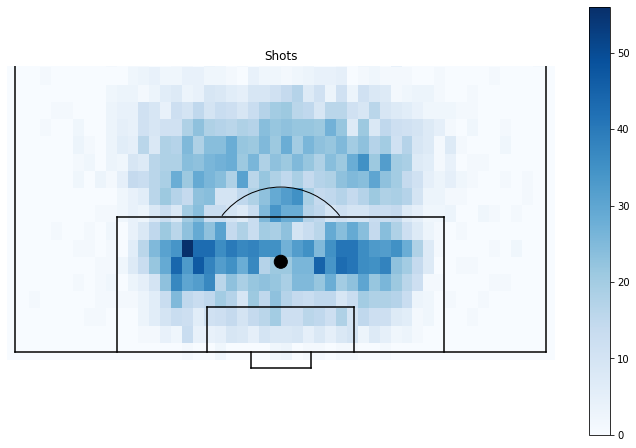

In [14]:
fig, ax = createGoalMouth()

position = ax.imshow(histo_shots[0], extent = [-1, 66, 104, -1],
                     aspect = "auto", cmap = plt.cm.Blues)

fig.colorbar(position, ax = ax)

ax.set_title("Shots")
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable = "box")
fig.set_size_inches((10, 7))
plt.show()

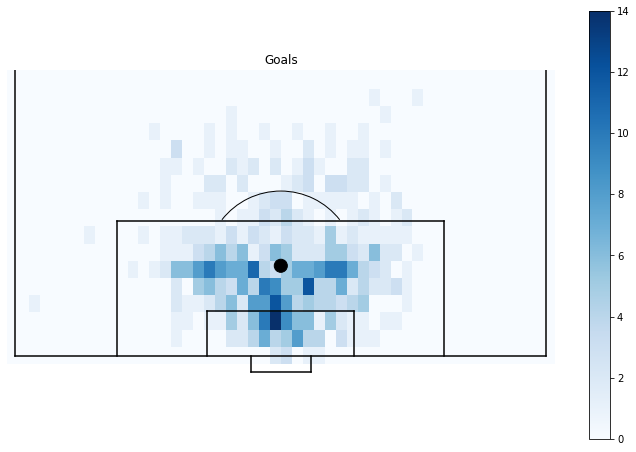

In [15]:
fig, ax = createGoalMouth()

position = ax.imshow(histo_goals[0], extent = [-1, 66, 104, -1],
                     aspect = "auto", cmap = plt.cm.Blues)

fig.colorbar(position, ax = ax)

ax.set_title("Goals")
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable = "box")
fig.set_size_inches((10, 7))
plt.show()

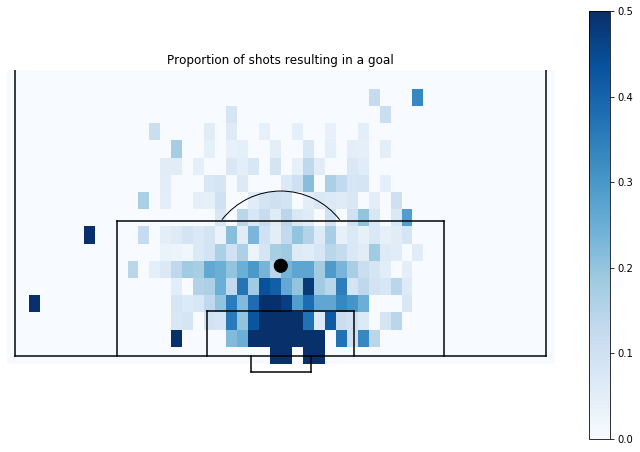

In [16]:
fig, ax = createGoalMouth()

# Dividing by histo_shots[0] works as well, but results in
# a DivisionByZero exception
position = ax.imshow(histo_goals[0] / (histo_shots[0] + 0.00000001),
                     extent = [-1, 66, 104, -1],
                     aspect = "auto", cmap = plt.cm.Blues,
                     vmin = 0, vmax = 0.5)

fig.colorbar(position, ax = ax)

ax.set_title("Proportion of shots resulting in a goal")
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect("equal", adjustable = "box")
fig.set_size_inches((10, 7))
plt.show()

---

In [4]:
with open(f"{WYSCOUT_BASE_PATH}/events_Italy.json", "r", encoding = "utf-8") as f:
    events = json.load(f)

df = pd.DataFrame(events)
df.head(1)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957


In [5]:
shots = df[df["eventName"] == "Shot"].copy()

shots["is_header"] = shots["tags"].apply(lambda x: True if 403 in [tag["id"] for tag in x] else False)
shots["is_goal"] = shots["tags"].apply(lambda x: 1 if 101 in [tag["id"] for tag in x] else 0)
shots = shots[shots.is_header == False].reset_index()

shots["x"] = shots["positions"].apply(lambda el: 100 - el[0]["x"])
shots["y"] = shots["positions"].apply(lambda el: el[0]["y"])
shots["d_center"] = shots["positions"].apply(lambda el: np.abs(el[0]["y"] - 50))

shots["x_meters"] = shots["x"].apply(lambda el: el * 1.05)
shots["y_meters"] = shots["d_center"].apply(lambda el: el * 0.65)

goal_width = 7.32

shots["distance"] = np.sqrt(shots.x_meters ** 2 + shots.y_meters ** 2)
shots["angle"] = np.arctan(goal_width * shots.x_meters / (shots.x_meters**2 + shots.y_meters**2 - (goal_width/2)**2))
shots["angle"] = shots["angle"].apply(lambda x: x + np.pi if x < 0 else x)

In [6]:
model = smf.glm(formula = "is_goal ~ x + angle + distance",
                      data = shots, 
                      family = sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                is_goal   No. Observations:                 7438
Model:                            GLM   Df Residuals:                     7434
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1851.5
Date:                Mon, 28 Jun 2021   Deviance:                       3703.0
Time:                        20:27:01   Pearson chi2:                 7.67e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3898      0.326     -1.196      0.232      -1.029       0.249
x              0.0830      0.025      3.350      0.001       0.034       0.132
angle          1.1002      0.278      3.964      0.000       0.556       1.644
distance      -0.2108      0.030     -7.036      0.000      -0.269      -0.152
==============================================================================
"""

In [7]:
model.params

Intercept   -0.389816
x            0.083015
angle        1.100170
distance    -0.210785
dtype: float64

In [8]:
model.predict(pd.DataFrame({"angle": [1], "distance": [5], "x": [10]}))[0]

0.6192998516438405

In [9]:
xg_probs = np.array([model.predict(pd.DataFrame({"angle": [row.angle],
                                                 "distance": [row.distance],
                                                 "x": [row.x]}))[0] for __, row in shots.iterrows()])

In [14]:
df_check = shots[["angle", "distance", "x", "y", "is_goal"]].copy()
df_check["xg"] = xg_probs

In [15]:
df_check.head()

,angle,distance,x,y,is_goal,xg
0,0.321317,21.799599,20,41,0,0.048752
1,0.274876,12.233765,5,33,0,0.095261
2,0.229221,30.590235,28,63,0,0.013910
3,0.468320,12.253265,9,62,0,0.153131
4,0.236713,21.434785,14,26,0,0.029733


In [12]:
n = len(df_check)
TP = np.zeros(n)
FP = np.zeros(n)
TN = np.zeros(n)
FN = np.zeros(n)

for i, threshold in enumerate(np.linspace(0, 1, 100)):
    for j, shot in df_check.iterrows():
        if shot.is_goal == 1: 
            if(shot.xg >= threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
                
        if shot.is_goal == 0: 
            if shot.xg >= threshold:
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

C:\Users\nicol\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


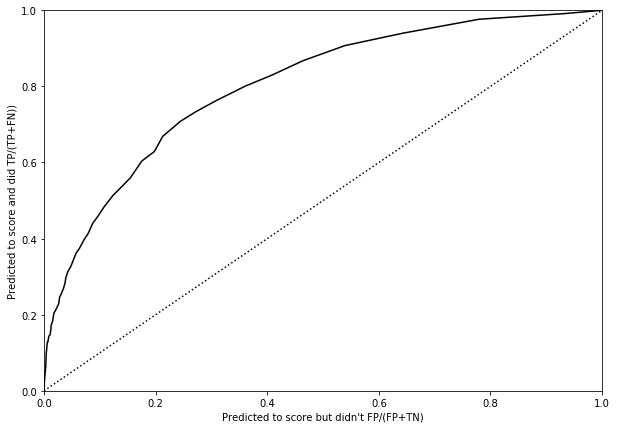

In [13]:
fig,ax = plt.subplots(figsize = (10, 7))
ax.plot(FP/(FP + TN), TP/(TP + FN), color = "k")
ax.plot([0,1], [0,1], linestyle = "dotted", color = "k")
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
plt.show()

In [26]:
prob_map = np.zeros((89, 99))

for idx, row in df_check.iterrows():
    prob_map[int(row["x"]-1), int(row["y"]-1)] = row.xg

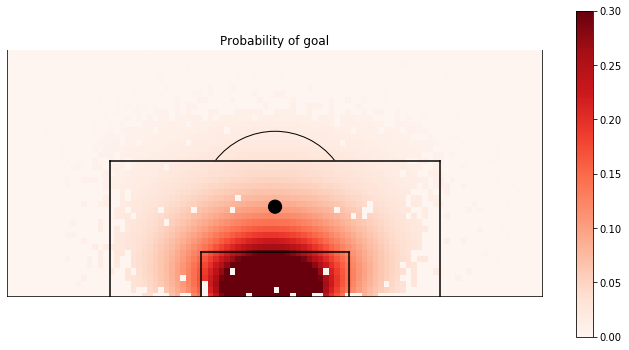

In [46]:
(fig, ax) = createGoalMouth()
pos = ax.imshow(prob_map, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,65))
plt.ylim((0,30))
plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches((12, 6))
plt.show()

---